In [186]:
import pandas as pd
import matplotlib.pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Download the data
!for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done
!for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done
!for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

--2016-11-29 12:27:19--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
           => “zbp93totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... 
Error in server response, closing control connection.
Retrying.

--2016-11-29 12:32:23--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
  (try: 2) => “zbp93totals.zip”
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... 
Error in server response, closing control connection.
Retrying.

--2016-11-29 12:37:26--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
  (try: 3) => “zbp93totals.zip”
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp93totals.zip ... d

In [20]:
# Test the reading of zip to dataframe
import zipfile

fname = 'zbp94totals.zip'
zf = zipfile.ZipFile(fname)
df94 = pd.read_csv(zf.open(fname.replace('.zip','.txt')))

print len(df94)
df94.head()

39259


,zip,name,empflag,emp,qp1,ap,est
0,1001,"Agawam, MA",NaN,6198,33601,155158,439
1,1002,"Amherst, MA",NaN,6073,28924,127367,450
2,1003,"Amherst, MA",NaN,68,367,1604,10
3,1004,"Amherst, MA",NaN,210,844,4302,47
4,1005,"Barre, MA",NaN,678,3010,13521,92


In [97]:
# Create a dictionary containing dataframes for each year's data, with the year as the key
import os
dfs = {}
for file in os.listdir("./"):
    if file.endswith("totals.zip"):
        fname = file
        if fname[3] == '9': 
            key = '19' + fname[3:5] 
        else:
            key = '20' + fname[3:5]
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
        # Standardize column names to lowercase
        df.columns = [x.lower() for x in df.columns]
        # Keep only zip and est (establishments) columns
        df = df[['zip', 'est']]
        dfs[key] = df

In [99]:
dfs['1994'].head()

,zip,est
0,1001,439
1,1002,450
2,1003,10
3,1004,47
4,1005,92


In [43]:
# 1993 data was not found on server, therefore we only have data for 19 years
print len(dfs.keys())

19

In [100]:
dfs[sorted(dfs)[0]].head()

,zip,est
0,1001,439
1,1002,450
2,1003,10
3,1004,47
4,1005,92


In [122]:
sorted(dfs)[0]

'1994'

In [125]:
# Merge all years, in chronological order, on zip code - resulting in timeseries of establishment counts for each zip
left = dfs[sorted(dfs)[0]]
for i in range(len(dfs)-1):
    left = pd.merge(left, dfs[sorted(dfs)[i+1]], on='zip', suffixes=('_' + sorted(dfs)[i], '_' + sorted(dfs)[i+1]))

left = left.rename(columns={'est':'est_2014'})
df_est = left
df_est.head()

,zip,est_1994,est_1995,est_1996,est_1997,est_1998,est_1999,est_2002,est_2003,est_2004,est_2005,est_2006,est_2007,est_2008,est_2009,est_2010,est_2011,est_2012,est_2013,est_2014
0,1001,439,439,433,457,444,469,490,505,500,509,509,503,477,458,448,436,453,439,458
1,1002,450,467,487,500,490,558,566,586,584,589,582,596,584,571,570,558,572,572,560
2,1003,10,10,13,15,14,13,15,16,15,12,12,16,17,16,16,16,15,15,18
3,1004,47,48,47,41,31,35,23,21,43,31,30,20,18,18,21,19,16,16,13
4,1005,92,95,101,104,95,82,94,93,97,94,98,106,97,87,96,91,94,97,97


In [127]:
df_est.shape

(35919, 20)

In [ ]:
!curl -O 'https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson'

In [15]:
import numpy as np
import geopandas as gp

# Store the geojson in a geodataframe
shape_path = "nyc-zip-code-tabulation-areas-polygons.geojson"
zip_shape = gp.GeoDataFrame.from_file(shape_path)
zip_shape.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [16]:
# Reduce to geometry and zip code only
zip_shape = zip_shape[['geometry', 'postalCode']]
zip_shape.head()

,geometry,postalCode
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [17]:
len(zip_shape)

262

In [150]:
# Merge geometry with establishment data
zip_shape = zip_shape.rename(columns={'postalCode':'zip'})
# zip_shape.head()
# print type(df_est['zip'][0])
# print type(zip_shape['zip'][0])
zip_shape['zip'] = zip_shape['zip'].astype(int)
print type(zip_shape['zip'][0])

est_shape = pd.merge(df_est, zip_shape, on='zip')
est_shape.head()

<type 'numpy.int64'>


,zip,est_1994,est_1995,est_1996,est_1997,est_1998,est_1999,est_2002,est_2003,est_2004,...,est_2006,est_2007,est_2008,est_2009,est_2010,est_2011,est_2012,est_2013,est_2014,geometry
0,10001,6999,7088,7075,7154,7254,7233,7141,7084,7370,...,7415,7549,7472,7305,7241,7227,7235,7273,7369,POLYGON ((-74.00827017711134 40.75258714368449...
1,10002,1784,1819,1919,2049,2003,2085,2269,2402,2551,...,2686,2685,2691,2775,2872,2912,2954,2988,2972,POLYGON ((-73.97441674489379 40.73642441865476...
2,10003,3256,3377,3417,3535,3649,3659,3616,3704,3776,...,3909,4049,4071,4099,4113,4159,4214,4277,4333,POLYGON ((-73.97986374196766 40.73497446573838...
3,10004,1115,1124,1133,1173,1176,1233,1253,1252,1283,...,1311,1370,1376,1379,1398,1404,1442,1479,1554,"POLYGON ((-74.00596661578348 40.7043243225291,..."
4,10004,1115,1124,1133,1173,1176,1233,1253,1252,1283,...,1311,1370,1376,1379,1398,1404,1442,1479,1554,POLYGON ((-74.04166368343016 40.69644987183209...


In [151]:
len(est_shape)

243

In [156]:
# Dataframe with zip as index, without geometry
est_zipindex = est_shape.iloc[:,:20].set_index('zip')
est_zipindex.head()

,est_1994,est_1995,est_1996,est_1997,est_1998,est_1999,est_2002,est_2003,est_2004,est_2005,est_2006,est_2007,est_2008,est_2009,est_2010,est_2011,est_2012,est_2013,est_2014
zip,,,,,,,,,,,,,,,,,,,
10001,6999,7088,7075,7154,7254,7233,7141,7084,7370,7312,7415,7549,7472,7305,7241,7227,7235,7273,7369
10002,1784,1819,1919,2049,2003,2085,2269,2402,2551,2682,2686,2685,2691,2775,2872,2912,2954,2988,2972
10003,3256,3377,3417,3535,3649,3659,3616,3704,3776,3867,3909,4049,4071,4099,4113,4159,4214,4277,4333
10004,1115,1124,1133,1173,1176,1233,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479,1554
10004,1115,1124,1133,1173,1176,1233,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479,1554


In [168]:
# Standardize each time series
est_zipindex = est_zipindex.sub(est_zipindex.mean(axis=1), axis=0)
est_zipindex.head()

,est_1994,est_1995,est_1996,est_1997,est_1998,est_1999,est_2002,est_2003,est_2004,est_2005,est_2006,est_2007,est_2008,est_2009,est_2010,est_2011,est_2012,est_2013,est_2014
zip,,,,,,,,,,,,,,,,,,,
10001,-253.421053,-164.421053,-177.421053,-98.421053,1.578947,-19.421053,-111.421053,-168.421053,117.578947,59.578947,162.578947,296.578947,219.578947,52.578947,-11.421053,-25.421053,-17.421053,20.578947,116.578947
10002,-694.842105,-659.842105,-559.842105,-429.842105,-475.842105,-393.842105,-209.842105,-76.842105,72.157895,203.157895,207.157895,206.157895,212.157895,296.157895,393.157895,433.157895,475.157895,509.157895,493.157895
10003,-590.315789,-469.315789,-429.315789,-311.315789,-197.315789,-187.315789,-230.315789,-142.315789,-70.315789,20.684211,62.684211,202.684211,224.684211,252.684211,266.684211,312.684211,367.684211,430.684211,486.684211
10004,-185.789474,-176.789474,-167.789474,-127.789474,-124.789474,-67.789474,-47.789474,-48.789474,-17.789474,-40.789474,10.210526,69.210526,75.210526,78.210526,97.210526,103.210526,141.210526,178.210526,253.210526
10004,-185.789474,-176.789474,-167.789474,-127.789474,-124.789474,-67.789474,-47.789474,-48.789474,-17.789474,-40.789474,10.210526,69.210526,75.210526,78.210526,97.210526,103.210526,141.210526,178.210526,253.210526


In [169]:
est_zipindex = est_zipindex.div(est_zipindex.std(axis=1), axis=0)
est_zipindex.head()

,est_1994,est_1995,est_1996,est_1997,est_1998,est_1999,est_2002,est_2003,est_2004,est_2005,est_2006,est_2007,est_2008,est_2009,est_2010,est_2011,est_2012,est_2013,est_2014
zip,,,,,,,,,,,,,,,,,,,
10001,-1.764192,-1.144618,-1.235118,-0.685159,0.010992,-0.135200,-0.775658,-1.172464,0.818527,0.414759,1.131794,2.064636,1.528600,0.366029,-0.079508,-0.176969,-0.121277,0.143260,0.811565
10002,-1.652385,-1.569152,-1.331345,-1.022195,-1.131587,-0.936585,-0.499020,-0.182736,0.171597,0.483124,0.492636,0.490258,0.504527,0.704285,0.934958,1.030081,1.129960,1.210814,1.172765
10003,-1.822512,-1.448943,-1.325449,-0.961141,-0.609183,-0.578310,-0.711066,-0.439379,-0.217090,0.063859,0.193528,0.625757,0.693679,0.780125,0.823348,0.965366,1.135170,1.329673,1.502565
10004,-1.464597,-1.393649,-1.322701,-1.007377,-0.983728,-0.534391,-0.376729,-0.384612,-0.140236,-0.321548,0.080491,0.545594,0.592892,0.616542,0.766320,0.813619,1.113177,1.404852,1.996084
10004,-1.464597,-1.393649,-1.322701,-1.007377,-0.983728,-0.534391,-0.376729,-0.384612,-0.140236,-0.321548,0.080491,0.545594,0.592892,0.616542,0.766320,0.813619,1.113177,1.404852,1.996084


In [175]:
est_zipindex.loc[10001].std()

1.0

In [189]:
# Cluster the timeseries

import sklearn.cluster
from sklearn import mixture

nc = 5
samples = est_zipindex
clf = sklearn.cluster.KMeans(n_clusters=nc)
labels = clf.fit_predict(samples)
print labels
len(labels)

# pl.imshow(labels, cmap='rainbow', interpolation='Nearest')
# pl.title("Akuma %d clusters"%nc, fontsize=20)
# pl.axis('off')
# pl.savefig("ak1.png")

[1 1 4 4 4 4 4 1 3 2 4 2 1 1 0 1 2 3 4 3 1 3 3 1 1 1 4 4 1 4 4 4 4 1 4 4 4
 2 4 2 4 1 1 2 4 2 2 2 3 0 0 0 0 3 3 1 4 3 1 0 3 3 3 1 3 3 0 0 0 0 2 3 3 4
 0 3 2 4 0 3 4 3 3 0 3 3 2 4 2 1 3 1 3 1 4 4 4 1 1 4 1 4 1 0 4 1 4 1 4 4 4
 4 4 4 4 4 1 4 4 4 2 2 2 4 1 4 4 4 0 0 4 1 1 4 4 1 3 4 1 1 4 1 4 4 1 4 4 4
 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 0 4 4 1 4
 4 4 1 4 4 1 4 4 2 4 4 4 4 4 4 4 4 1 4 4 1 4 4 4 4 4 4 1 4 2 1 4 4 4 4 4 4
 4 1 0 4 4 1 2 1 1 4 4 4 2 4 4 4 4 4 4 4 1]


243

[[ 1.06798209  0.72898224  0.21180803 -0.06082305 -0.2750942   0.03729396
  -1.0228301  -1.03302133 -0.52634348 -0.46626424 -0.41780795 -0.35008617
  -0.28690274 -0.12216137 -0.04623274  0.14192335  0.69930618  0.71712076
   1.00315077]
 [-1.92460177 -1.58031754 -1.34327253 -0.95900571 -0.81404911 -0.63360773
  -0.101751    0.11357602  0.39684727  0.49096323  0.58210395  0.6207184
   0.59899538  0.58534618  0.62713943  0.70306729  0.74231378  0.85854927
   1.0369852 ]
 [-0.83463853 -0.69605652 -0.34619559 -0.07653241  0.07865977  0.00758672
   0.9235235   0.98599824  1.22805929  0.6799286   0.36809757  0.13405864
  -0.16640205 -0.45038553 -0.57241073 -0.79087652 -0.39127193 -0.0624454
  -0.01869713]
 [ 0.59361362  0.91525431  0.94193892  1.03598866  1.12046136  1.26697365
   0.17832706 -0.0488944   0.05473202  0.05357648  0.03487571 -0.16594777
  -0.36598794 -0.50863902 -0.70059252 -0.93669586 -1.1643029  -1.16169852
  -1.14298286]
 [-1.31269123 -1.27456392 -1.17342413 -1.05404377 -0.9

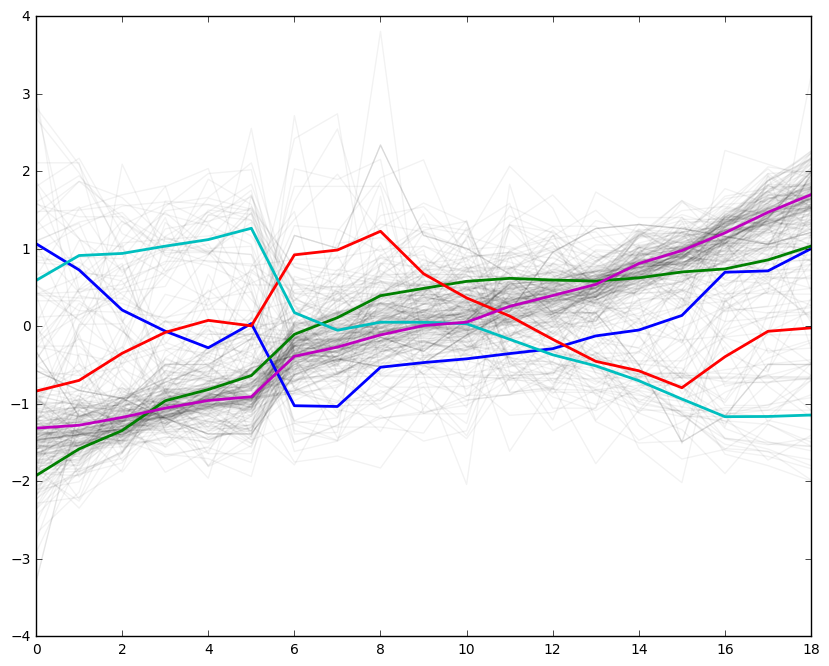

In [213]:
print clf.cluster_centers_

pl.figure(figsize=(10,8))
x = range(19)
# print shape(x)
# print est_zipindex.T.shape

pl.plot(x, est_zipindex.T, '-', c='k', alpha=0.05)
pl.plot(x, clf.cluster_centers_.T, '-', lw=2)

# for i in range(nc):
#     fig = pl.figure(figsize=(8,8))
#     k=0
#     for j,f in enumerate(listf[clf.labels_==i]):
#         k=k+1
#         ax = fig.add_subplot(8,5,k)
#         ax.axis('off')
#         im = imread(f)
#         ax.imshow(im)
#     figmean = pl.figure(figsize=(5,5)).add_subplot(111)   
#     figmean.imshow(np.log10(clf.cluster_centers_[i]).reshape(200,139,4))
#     #pl.hist(clf.cluster_centers_[i])
#     figmean.axis('off')   
# print ("number of clusters: ", nc)

# figmean.imshow(np.log10(clf.cluster_centers_[i]).reshape(200,139,4))
